In [1]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import sys
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "svg"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

sys.path.append("..")
from swarmalatorlib.template import Swarmalators2D

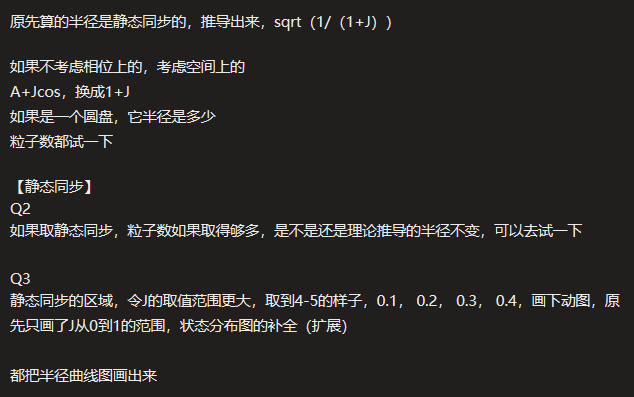

In [2]:
from main import Strogatz2017, Strogatz2017Fix

In [2]:
class Strogatz2017Fix(Swarmalators2D):
    def __init__(self, agentsNum: int, dt: float, 
                 K: float, J: float, 
                 randomSeed: int = 100, tqdm: bool = False, savePath: str = None, shotsnaps: int = 5) -> None:
        super().__init__(agentsNum, dt, K, randomSeed, tqdm, savePath, shotsnaps)
        self.J = J
        self.one = np.ones((agentsNum, agentsNum))
        self.phaseTheta = np.zeros(agentsNum)

    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction: 1 + J
        """
        return 1 + self.J * self.one
    
    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion: 1"""
        return self.one
    
    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: (x_j - x_i) / |x_j - x_i|"""
        return self.div_distance_power(numerator=self.temp["deltaX"], power=1)
    
    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: (x_j - x_i) / |x_j - x_i| ^ 2"""
        return self.div_distance_power(numerator=self.temp["deltaX"], power=2)
    
    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return 0

    def update_temp(self):
        self.temp["deltaX"] = self.deltaX
        self.temp["distanceX2"] = self.distance_x_2(self.temp["deltaX"])


    @staticmethod
    @nb.njit
    def _update(
        positionX: np.ndarray, phaseTheta: np.ndarray,
        velocity: np.ndarray, omega: np.ndarray,
        Iatt: np.ndarray, Irep: np.ndarray,
        Fatt: np.ndarray, Frep: np.ndarray,
        H: np.ndarray, G: np.ndarray,
        K: float, dt: float
    ):
        dim = positionX.shape[0]
        pointX = velocity + np.sum(
            Iatt * Fatt.reshape((dim, dim, 1)) - Irep * Frep.reshape((dim, dim, 1)),
            axis=1
        ) / (dim - 1)
        positionX += pointX * dt
        return positionX, phaseTheta
    
    def __str__(self) -> str:
        return f"Strogatz2017_a{self.agentsNum}_K{self.K}_J{self.J:.2f}_fix"


class Strogatz2017(Swarmalators2D):
    def __init__(self, agentsNum: int, dt: float, 
                 K: float, J: float, 
                 randomSeed: int = 100, tqdm: bool = False, savePath: str = None, shotsnaps: int = 5) -> None:
        super().__init__(agentsNum, dt, K, randomSeed, tqdm, savePath, shotsnaps)
        self.J = J
        self.one = np.ones((agentsNum, agentsNum))

    @property
    def Fatt(self) -> np.ndarray:
        """
        Effect of phase similarity on spatial attraction: 1 + J * cos(theta_j - theta_i)
        """
        return 1 + self.J * np.cos(self.temp["deltaTheta"])

    @property
    def Frep(self) -> np.ndarray:
        """Effect of phase similarity on spatial repulsion: 1"""
        return self.one
    
    @property
    def Iatt(self) -> np.ndarray:
        """Spatial attraction: (x_j - x_i) / |x_j - x_i|"""
        return self.div_distance_power(numerator=self.temp["deltaX"], power=1)
    
    @property
    def Irep(self) -> np.ndarray:
        """Spatial repulsion: (x_j - x_i) / |x_j - x_i| ^ 2"""
        return self.div_distance_power(numerator=self.temp["deltaX"], power=2)
    
    @property
    def velocity(self) -> np.ndarray:
        """Self propulsion velocity: 0"""
        return 0
    
    @property
    def omega(self) -> np.ndarray:
        """Natural frequency: 0"""
        return 0
    
    @property
    def H(self) -> np.ndarray:
        """Phase interaction: sin(theta_j - theta_i)"""
        return np.sin(self.deltaTheta)
    
    @property
    def G(self) -> np.ndarray:
        """Effect of spatial similarity on phase couplings: 1 / |x_i - x_j|"""
        return self.div_distance_power(numerator=self.one, power=1, dim=1)
    
    def __str__(self) -> str:
        return f"Strogatz2017_a{self.agentsNum}_K{self.K}_J{self.J:.2f}"

In [18]:
model = Strogatz2017(agentsNum=1000, dt=0.01, K=0.2, J=1, tqdm=True, savePath="data", shotsnaps=1)

In [17]:
model.run(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

..\swarmalatorlib\template.py:83: RuntimeWarning: invalid value encountered in true_divide
  answer = numerator / self.temp["distanceX2"] ** power
..\swarmalatorlib\template.py:85: RuntimeWarning: divide by zero encountered in true_divide
  answer = numerator / self.temp["distanceX"] ** power
..\swarmalatorlib\template.py:83: RuntimeWarning: invalid value encountered in true_divide
  answer = numerator / self.temp["distanceX2"] ** power
..\swarmalatorlib\template.py:85: RuntimeWarning: divide by zero encountered in true_divide
  answer = numerator / self.temp["distanceX"] ** power
..\swarmalatorlib\template.py:83: RuntimeWarning: invalid value encountered in true_divide
  answer = numerator / self.temp["distanceX2"] ** power
..\swarmalatorlib\template.py:85: RuntimeWarning: divide by zero encountered in true_divide
  answer = numerator / self.temp["distanceX"] ** power
..\swarmalatorlib\template.py:83: RuntimeWarning: invalid value encountered in true_divide
  answer = numerator / self

KeyboardInterrupt: 

In [8]:
positionX = model.positionX
centor = positionX.mean(axis=0)
distance = np.linalg.norm(positionX - centor, axis=1)
np.mean(np.sort(distance)[-int(model.agentsNum * 0.01):])

0.5623203202935109

In [15]:
max(((positionX - centor)[:, 0] ** 2 + (positionX - centor)[:, 1] ** 2) ** 0.5)

0.5630585870802425

In [7]:
from itertools import product

Jrange = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1),
    np.arange(1, 11, 1)
])
agentsNumRange = np.arange(1000, 5001, 1000)


models = [
    Strogatz2017(agentsNum=agentsNum, dt=0.1, K=1, J=J, 
                 fixSpiralPhaseCoupling=True, randomSeed=randomSeed, 
                 tqdm=True, savePath="data", shotsnaps=1)
    for J, agentsNum in tqdm(product(Jrange, agentsNumRange), total=len(Jrange) * len(agentsNumRange))
]

  0%|          | 0/145 [00:00<?, ?it/s]

In [ ]:
def run_model(model):
    model.run(2000)

with Pool(40) as p:
    p.map(run_model, models)

  0%|          | 0/101 [00:00<?, ?it/s]

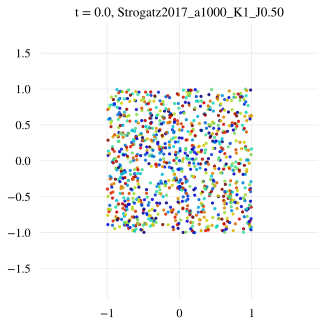

In [8]:
targetPath = f"./data/{model}.h5"

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")

TNum = totalPositionX.shape[0] // model.agentsNum

totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)

positionLim = np.max(np.abs(totalPositionX)) * 1.1

# TNum = 100
pbar = tqdm(total=TNum)

def plot_frame(i):
    if model.tqdm:
        pbar.update(1)
    positionX = totalPositionX[i]
    phaseTheta = totalPhaseTheta[i]

    # fig.clear()
    ax.clear()
    ax.scatter(positionX[:, 0], positionX[:, 1], s=5, c=phaseTheta, cmap=new_cmap, vmin=0, vmax=2 * np.pi, alpha=0.8)
    ax.set_xlim(-positionLim, positionLim)
    ax.set_ylim(-positionLim, positionLim)
    ax.set_title(f"t = {i * model.dt:.1f}, {model}")

fig, ax = plt.subplots(figsize=(5, 5))
ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, TNum), interval=50, repeat=False)
ani.save(f"{model}.mp4", dpi=200)

In [7]:
positionLim

nan